# Modelling and testing stem cell populations with Python

## Introduction

Stem cells maintain the structure of tissues and organs in the body. How they grow and divide is a subject of intensive study, but one concept has been explored heavily over the past decade and found to describe how the stem cell population is maintained in many different tissues.  In this tutorial we will give concrete examples of how to build simulators that explore how changing one part of the model alters cell growth, and compare the model behaviour against experimental data.

![Schematic of single progenitor model](Cartoon.png)

In this tutorial we are going to explore one part of the single progenitor model (depicted above). The model has two types of cell; stem cells and differentiated cells. Stem cells divide to give two daughter cells, which can either be one stem cell and one differentiated cell (asymmetric division), both stem cells, or both differentiated cells (symmetric division). As the population of stem cells is constant, the probability of both possible symmetric divisions is equal, so over time, on average, one stem cell gives one differentiated cell and one stem cell.

In the past the division (sometimes written as $\lambda$) and stratification (sometimes written as $\Gamma$) times have been modelled as following an exponential distribution. Recent experiments have suggested that this is inappropriate and may bias our analysis. Here we will build simulators that use more complex distributions and see how they change the model behaviour by both direct comparison with experimental data and by exploring the general properties.

This document has a parallel document written in F#, performing the same functions using different available libraries. Where sensible functions with the same task have the same name. By referring to both of them you can see how similar tasks can be accomplished in both languages.

### Background biology

Whilst this tutorial has been written to focus on aspects of the maths and programming, the code and text necessarily use a few technical terms. This section introduces some of them and how they are used here.

A *cell* is the basic unit of living matter- it eats, divides, dies, and carries out functions specific to the tissue its in. The cell *fate* is the cells function, and in this model is determined on birth. This dictates what that cell can go on to do in the future. In this model, one cell fate is to be a *stem cell*. Stem cells will go on to divide at some point in the future. The *cell cycle* is the process that immediate proceeds division. This is expected to last an average length of time for a given cell type, but the distribution of times is not necessarily known. The alternative cell fate in this model is to *differentiate*; in this case the cell will stop dividing, and eventually leave the space that stem cells occupy by a process called *stratification*. 

A *clone* is the set of descendants from a single cell at a specific point in time. These could be defined by a natural event- such as a mutation- or a result of an experiment. A common experiment known as *lineage tracing* is to monitor the size of clones in growing tissues is to add an *inheritable*, permenant coloured label to cells at a specific timepoint. As the label is inheritable all of the cells in a clone will carry it, and can be distinguished and counted under a microscope.

Another type of labelling experiment involves the use of a *histone* label. This label is switched on during the experiment similar to lineage tracing. However, the labelled histone stops being produced after the experiment is started, though cells continue to produce unlabelled histones. This means that every time the cell divides the amount of label halves, allowing cell divisions to be tracked over time.

## Plan and constraints

In this document we will present code to do 4 different tasks:

1. Simulate cell fates to show how clones compete neutrally to dominate the tissue
2. Take the results of those simulations and study the effect of different cell-cycle time distributions by generating random numbers taken from different distributions.
3. Simulate an experiment where a label becomes more dilute every time a cell divides
4. Use this simulator with an ''Approximate Bayesian Computation'' based analysis to find out which distribution best describes some collected data.

In doing so we will look to report and plot data as a we go along to confirm that different parts of the code are working. Wherever possible we use external libraries to perform calculations rather than reimplement the functions.

We also specify a seed for random number generation for calculations. This is to help ensure repeatability.

## Machine variables

These variables are referenced by the code below and are machine specific- *you need to alter these for some functions to work!* 

The comments indicate what they should be set to and what they are used for.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [2]:
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp




In [4]:
%load_ext line_profiler
%load_ext memory_profiler

# Simulating cell fates

![Dendrograms of cell fates](CellFate.png)

The first behaviour we will simulate is fate determination of cells in a clone, starting from a single cell. This is the pattern of changing cell states as cells go on to divide. Examples of cell fates are drawn as dendrograms above. In (A), A cell divides, but neither daughter cell is a stem cell and so division stops. In (B), the divisions form a more complex (and unfinished pattern)- in the first division the cell fates are asymmetric giving one stem cell and one differentiated cell. That stem cell divides to give two stem cells, and so on until either all daughter cells in the clone divide becoming differentiated cells, or we stop the experiment

In this specific situation we are only simulating the fates- that is to say, we know that division and stratification occur at different rates, but we are not taking account of that yet- we just record the order in which things happened in discrete time. Even without precise timings we expect the functions to give us some of the key properties of the clone growth. 

We define a clone through a record type, where we record when the clone was born (*birthtime*), when the cell left the clone (*lifeTime*), the random number generator used to determine the next fate (*rng*), whether the cell is a stem cell (*stem*) and the probability of dividing to give daughters with the same cell fate (*r*). We also include a list of other clones that the clone has given birth to (*sibling*), and an integer used to assign a unique identity to every cell created (*identity*). Note we have defined other elements in the record, which we use in future.

The function *fateSimulate* simulates the life of a single cell. Given a clone record, a maximum number of divisions (*limit*), and a reference variable used to track unique identities (*idTrack*) it loops through events in the cells life, giving a final clone with some variables changed. 

In each loop fateSimulate first tests whether the cell has been simulated enough times, and if it has returning a modified version of the last state of the cell. This is either the last state with the lifetime set to the current time (and a Boolean variable, *survivor*, set to true to indicate this), or if the cell is not a stem cell at the end of the simulation, the last state with the lifetime set to the current time+1. 

Next, if the cell is still a stem cell, it creates a new daughter cell as a copy of the parent, with a new unique identity value. We then determine using r and a random number whether the daughter and parent are stem cells after division, defining a new cell to replace the parent and the daughter. Finally, we restart the loop using the replacement cell with the daughter added to the list of siblings.

This however is not sufficient- we want to simulate all the daugter cells as well to see how the clone grows. To do this we define a recursive function *cloneSimulateInternal*, which simulates a single cell, then recursively runs on all of the daughter cells (and their daughter cells and so on), appending only the key information as a tuple to list reference. This function itself is run through *cloneSimulate*, which sorts the final list by unique identifier (this is important for later functions).

Finally, the function *experiment* is defined which takes a list of discrete timepoints, runs cloneSimulate, and asks how many cells are alive at each time.

In [5]:
'''
A cell should update to divide and die. As we can only count living cells, 
we only need to measure the lifetime of a cell or experiment, and store its 
siblings.

For the whole clone size, each of the siblings need to be simulated to their
stratification or the end of the experiment.

The cell updates in discrete time, with an aim that randomly generated times 
are projected back on a cohort a posteri to reduce calculation times.
'''
        
class cell:
    def __init__(self,init,stem,r,rng):
        self.currentTime = init
        self.stem = stem
        self.r = r
        self.rng = rng
        self.lifetime = 0
        self.birthtime = self.currentTime
        self.survivor = False
        self.siblings = []
    def printState(self):
        response = "Time\t%d\nStem\t%r\n" % (self.currentTime, self.stem)
        print(response)
    def printParameters(self):
        response = "Lambda\t%f\nr\t%f\nrho\t%f\n" % (self.lam, self.r, self.rho)
        print(response)
    def printHistory(self):
        response = "Siblings\t%d\tBirth\t%f\tDeath\t%f\n" % (len(self.siblings), self.birthtime, self.lifetime)
        print(response)
    def simulate(self,limit):
        cont = True
        while(cont):
            if self.lifetime > 0:
                cont = False
            elif self.currentTime>limit:
                #End experiment- lifetime set to currenttime+1 if not a stem cell, currenttime if stem with surv bool set
                #Infinity is inappropriate as its a float, so setting lifetime to current time
                #If a clone has infinity *before* the last experimental timepoint, the simulation needs extension
                if self.stem:
                    self.survivor = True
                    self.lifetime = self.currentTime
                else:
                    self.lifetime = self.currentTime+1
                cont = False
            else:
                if self.stem:
                    self.currentTime += 1
                    sibling = cell(self.currentTime,self.stem,self.r,self.rng)
                    rand = self.rng.random()
                    if rand < self.r:
                        pass
                    elif rand < (self.r*2):
                        self.stem = False
                        sibling.stem = False
                    else:
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
                    self.currentTime += 1
                    self.lifetime = self.currentTime
                

'''
Simulates a cell up to an event limit, storing the discrete times only
'''
def cloneSimulateDiscreteTime(i,limit,acc):
    i.simulate(limit)
    acc.append((i.birthtime,i.lifetime))
    for s in i.siblings:
        cloneSimulateDiscreteTime(s,limit,acc)
    return(acc)

'''
Simulates a cell up to an event limit, storing the cell as result
'''
def corecloneSimulateComplete(i,acc,parent,nameMarker,limit):
        i.simulate(limit)
        #update namemarker for a unique name
        nameMarker[0]+=1
        name = nameMarker[0]
        acc.append((i.birthtime,i.lifetime,parent,i.survivor)) #Switching to numpy array here leads to a 20x slowdown!
        for s in i.siblings:
            corecloneSimulateComplete(s,acc,name,nameMarker,limit)
        return((acc)) #adding np.asarray gives 20x slowdown
def cloneSimulateComplete(i,limit):
    return(corecloneSimulateComplete(i,[],-1,[-1],limit))

def experimentDiscreteTime(c,timePoints):
    limit = max(timePoints)
    lifespans = cloneSimulateDiscreteTime(c,limit,[])
    def within(a,b,c):
        if c>a and c<=b:
            return(1)
        else:
            return(0)
    return([sum([within(b,d,t) for (b,d) in lifespans]) for t in timePoints])
    

def printClone(c):
    def core(c,d):
        print("Gen\t%d" % d)
        c.printHistory()
        for i in c.siblings:
            core(i,d+1)
    core(c,0)

def seedExperiment(i):
    random.seed(i)
    return(experimentDiscreteTime(cell(0,True,0.25,random),[2,4,8,10,30,50,100]))

#uni = uniformGenerate(1982,None)
def seedClone(i):
    random.seed(i)
    return(cloneSimulateComplete(cell(0,True,0.25,random),100))

## Testing the simulator

Below we can run a few tests. We initially define a cell and run a simulation just of that. We go on to simulate a clone, and an experiment to see if the functions run and generate sensible outputs. 

We finish with a simulation of 10000 clones, timing the calculation. As the most easily measurable properties of the model are the averages, we will use this for generating some plots. To ensure that our random numbers are really random we can look at a couple of elements in the array and compare them.

In [6]:
a = cell(0,True,0.25,random)

a.simulate(10)

a.printHistory()

Siblings	6	Birth	0.000000	Death	7.000000



In [7]:
random.seed(1982)
b = cell(0,True,0.25,random)
r = experimentDiscreteTime(b,[2,4,8,10])
r

[2, 2, 2, 0]

In [8]:
seedExperiment(4)

[2, 8, 12, 24, 12, 36, 26]

In [9]:
random.seed(1982)
b = cell(0,True,0.25,random)
r = cloneSimulateComplete(b,30)
#printClone(r)
r

[(0, 7, -1, False),
 (1, 2, 0, False),
 (2, 3, 0, False),
 (3, 8, 0, False),
 (4, 5, 3, False),
 (5, 6, 3, False),
 (6, 7, 3, False),
 (7, 8, 3, False),
 (4, 5, 0, False),
 (5, 6, 0, False),
 (6, 7, 0, False)]

In [10]:
random.seed(200)
b = cell(0,True,0.25,random)
r = cloneSimulateComplete(b,10)
#printClone(r)
r

[(0, 7, -1, False),
 (1, 4, 0, False),
 (2, 6, 1, False),
 (3, 5, 2, False),
 (4, 5, 3, False),
 (4, 8, 2, False),
 (5, 8, 5, False),
 (6, 7, 6, False),
 (7, 8, 6, False),
 (6, 7, 5, False),
 (7, 8, 5, False),
 (5, 6, 2, False),
 (3, 4, 1, False),
 (2, 5, 0, False),
 (3, 6, 13, False),
 (4, 5, 14, False),
 (5, 6, 14, False),
 (4, 5, 13, False),
 (3, 4, 0, False),
 (4, 10, 0, False),
 (5, 6, 19, False),
 (6, 9, 19, False),
 (7, 8, 21, False),
 (8, 9, 21, False),
 (7, 11, 19, True),
 (8, 9, 24, False),
 (9, 11, 24, True),
 (10, 11, 26, False),
 (11, 12, 26, False),
 (10, 11, 24, True),
 (11, 11, 29, True),
 (11, 12, 24, False),
 (8, 11, 19, True),
 (9, 10, 32, False),
 (10, 11, 32, True),
 (11, 12, 34, False),
 (11, 12, 32, False),
 (9, 10, 19, False),
 (5, 6, 0, False),
 (6, 7, 0, False)]

In [11]:
%time lots = np.asarray( [np.asarray(seedExperiment(i)) for i in range(10000)] ) 
%time lotsClone = np.asarray( [np.asarray(seedClone(i)) for i in range(10000)] ) 

Wall time: 3.72 s
Wall time: 3.24 s


## Properties of a collection of clones

Lets run some experiments in a similar way to the code above, and check the properties. 

The model represents homeostasis, so we expect that there should be roughly 20000 cells at each timepoint, which we can check by summing for all elements. 

We also expect the average surviving clone size to increase linearly over time with a slope of ~0.5. This can be seen by calculating and plotting this using matplotlib.

Finally, the number of surviving clones should drop over time following a power law- again we can plot and check this using matplotlib.

In [12]:
sum(lots)

array([20000, 20172, 20468, 20414, 20668, 20496, 20000])

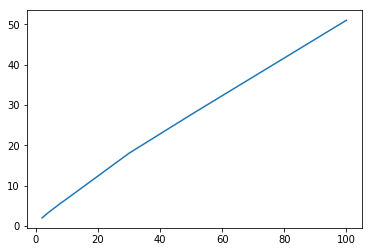

In [13]:
plt.plot([2,4,8,10,30,50,100],[ stats.tmean(i,limits=(1,None)) for i in np.transpose(lots)])

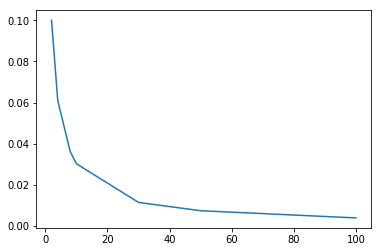

In [14]:
plt.plot([2,4,8,10,30,50,100],np.array([ np.count_nonzero(i) for i in np.transpose(lots)])/100000)

# Converting clone lifespan to realistic times

The fate simulator is able to generate the orders of events in a clones lifetime, but in order to compare this with experimental data we need to use the outputs from that function, and transform them into floating point numbers that reflect the division and stratification rates. The most common way to do this is to draw the division times from an exponential distribution characterised by its mean, but we also know that the exponential distribution is unrealistic for cell division times. Here we explore two alternative distributions used in the literature; a short, deterministic delay (the delay or refractory period) followed by an exponential distribution, and a deterministic lag period followed by times selected from a gamma distribution (with an additional shape parameter). As the exponential distribution is a special case of the gamma distribution where the shape is 1., we can focus on using just the gamma distribution when we start to compare with experimental data.

We first define functions that allow us to set create a random number generator for a given distribution with a specific set of parameters (using the numpy library to generate the underlying distribution). In each case the overall mean time for events to occur and a random number generator is passed to the function. In addition to this, a delay may be passed (either as an absolute delay, or expressed as a fraction of the mean) and a shape parameter. In each case the object returned is a function that takes unit as an input and returns a new floating point number from the distribution.

In each case we use an object that preallocates a large number of random numbers (*total*) and defines functions that return one, or an array of random numbers of a specified size, cumulatively summed. The functions that return values determine whether the store of numbers will run out and regenerates a set periodically. This is written like this for performance purposes. 

In [15]:
class timeGenerate:
    def __init__(self,seed,params):
        np.random.seed(seed)
        self.total = 10000000
        self.params = params
        self.validate()
        #Generate "total" times
        self.regenerate()
    def regenerate(self):
        self.precalculated = np.ones(self.total)
        self.position = 0
    def next(self,n=1):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            result = np.cumsum(self.precalculated[self.position:self.position+n])
            self.position+=n
            return(result)
    def nextOne(self):
        if (1+self.position>self.total):
            self.regenerate()
            return(self.nextOne())
        else:
            result = self.precalculated[self.position]
            self.position+=1
            return(result)
    def nextTerminated(self,n=1,terminator=None):
        if (n+self.position>self.total):
            self.regenerate()
            return(self.next(n))
        else:
            times = self.precalculated[self.position:self.position+n]
            #This replaces a value! it will not be reused and eventually will be regenerated though
            times[-1] = terminator.nextOne()
            result = np.cumsum(times)
            self.position+=n
            return(result)
    def validate(self):
        pass
    def drawTimes(self,limit):
        counter = 0
        totalTime=0
        while(totalTime<limit):
            totalTime+=self.precalculated[self.position+counter]
            counter+=1
            if counter+self.position>self.total:
                self.regenerate()
                return(self.drawtimes(limit))
        return(self.next(counter))
        

class halfTime(timeGenerate):
    def regenerate(self):
        self.precalculated = np.ones(self.total)/2
        self.position = 0
        
class exponentialGenerate(timeGenerate):
    def regenerate(self):
        (mean) = self.params
        self.precalculated = np.random.exponential(mean,self.total)
        self.position = 0

class uniformGenerate(timeGenerate):
    def regenerate(self):
        #(lower,upper) = self.params
        self.precalculated = np.random.uniform(0,1,self.total)
        self.position = 0

class exponentialGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,delay) = self.params
        self.precalculated = np.random.exponential((mean-delay),self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[1])

class gammaGenerate(timeGenerate):
    def regenerate(self):
        (shape,scale) = self.params
        self.precalculated = np.random.gamma(shape,scale,self.total)
        self.position = 0

class gammaGenerateDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean-delay)/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay
        self.position = 0
    def validate(self):
        assert(self.params[0]>self.params[2])

#More elegant way of expressing the delay
class gammaGenerateFractionalDelay(timeGenerate):
    def regenerate(self):
        (mean,shape,delay) = self.params
        scale = (mean*(1-delay))/shape
        self.precalculated = np.random.gamma(shape,scale,self.total)+delay*mean
        self.position = 0
    def validate(self):
        assert(0<=self.params[2])
        assert(self.params[2]<=1)

## Converting discrete time to real time

The function *correctTime* below takes two random number generator objects (of the type we have just defined above), an initial time, and an array of tuples generated by the cloneSimulate function defined above. It returns a new array with the time of birth and the time of loss of the cell. 

To do this we first generate an array with random numbers drawn from the function representing the division times. If the cell stratifies we replace the last number in the array with a value drawn from the function representing stratification times. Finally, we perform a cumulative sum so that all elements represent the times taken for each event to happen from an initial timepoint (here arbitrarily set to zero).

This gives us a series of timepoints that are accurate relative to the time when the cell was first born. However, we need the times to be relative to the start of the experiment to be useful. To do this for each cell we need to look at the times of its parent (and in turn, its parents and grandparents until the original cell) and adjust all the timepoints by the time the cell was born. Uniquely, the original cell has a parent set to a negative value and if this is found in the loop, the initial time is set to the value passed when calling the function.

As an example, we want to generate times for the third cell in a clone. The third cell is a daughter of the first. The discrete times are 

cell 1 born @ 0, lost @ 3
cell 3 born @ 1, lost @ 2

This will give us initially two arrays of timepoints;

cell1 = [|0.;0.5;1.0;1.5;|]
cell3 = [|0.;1.0|]

For cell 3, assuming that the initial time of the experiment was 0 (so cell 1 remains unchanged), we then need to add 0.5 (the first time from cell 1) to every timepoint. We get this by using the discrete birthtime as an index in the array. Finally, we return the first and last elements of the new array as the time of birth and the time of death; 0.5 and 1.5.

This relies on being able to look up the parent time. Earlier we sorted the array returned by cloneSimulate by the unique identifier- this allows us to use the parent id (stored in the tuple) as an index in the original search. It also ensures that we correct the times in order of cell creation- this is important as when we correct the times we mutate the values in the original array, and ensures that we have always corrected the parents before we update their children. 

We now have enough information to directly compare our results with lineage tracing data.

In [16]:
def correctTime(c,initial,division,stratification,limit):
    #c is tuple of birth,death,parent,survival (int*int*int*bool)
    #First get all the relative times for all the clones, measured from birth. 
    eventTimes = [((division.next(d-b),b,d,p) if s else (division.nextTerminated(d-b,terminator=stratification),b,d,p) ) for (b,d,p,s) in c ]

    #Second correct the intial times of all of the events and store to the acc
    def includeBirth(times,birthday,deathday,parent):
        #modifier is going to be calculated from the birthtime, and the time of the parent
        #this relies on mutables. Potential for ugliness
        #Your parent's life times are stored by index- so if you parent is x, the lifetimes are in eventTimes[x]
        #Times are in the first element of the eventTimes tuple- eventTimes[x][0]
        #Your birthday (n) is the (n-1)th event in the parents life- so its in eventTimes[x][0][n-1*]
        #Your parents birthday needs to be taken into account too; so if your parent was born on 3 and you on 6 you need n-pbday-1
        #print(times)
        if parent<0:
            #special case- the initial cell
            times+=initial
            return((initial,times[-1])) 
        else:
            parentBirthday = eventTimes[parent][1]
            timeOnBirth=eventTimes[parent][0][birthday-parentBirthday-1]
            if(len(times)):
                times+=timeOnBirth
                return( (timeOnBirth, times[-1] ) )
            else:
                #special case- this is a cell born on the last time point. Arbitrarily set to infinity
                #Note differentiated cells born on the last timepoint have their lifetime extended, so this is only stem cells
                return((timeOnBirth,math.inf))
    acc = [includeBirth(times,birthday,deathday,parent) for (times,birthday,deathday,parent) in eventTimes]

    return(acc)

## Testing functions

Here we demonstrate how different functions we've defined work. We explore the random number generators, then test elements of the large array of clone simulations we defined above (called *lots*), before applying the function to all elements and timing it.

In [17]:
random.seed(1982)
np.random.seed(1982)
b = cell(0,True,0.25,random)
r = cloneSimulateComplete(b,30)
#printTime(r,0,0)

In [18]:
def printTime(c,initial,gen):
    print("Gen %d" % gen)
    birth = c.birthtime
    death = c.lifetime
    timePoints = death-birth
    realTimes = getTimes(timePoints,initial)
    print(realTimes)
    response = "Siblings\t%d\tBirth\t%d/%f\tDeath\t%d/%f\n" % (len(c.siblings), birth, initial, death, realTimes[-1])
    print(response)
    for i,t in zip(c.siblings,realTimes):
        printTime(i,t,gen+1)

In [19]:
random.seed(1982)
np.random.seed(1982)
b = cell(0,True,0.25,random)
r = cloneSimulateComplete(b,30)
r

[(0, 7, -1, False),
 (1, 2, 0, False),
 (2, 3, 0, False),
 (3, 8, 0, False),
 (4, 5, 3, False),
 (5, 6, 3, False),
 (6, 7, 3, False),
 (7, 8, 3, False),
 (4, 5, 0, False),
 (5, 6, 0, False),
 (6, 7, 0, False)]

In [20]:
g = timeGenerate(1982,())
h = halfTime(1982,())

In [21]:
correctTime(r,0,g,h,10)
#printClone(r)

[(0, 6.5),
 (1.0, 1.5),
 (2.0, 2.5),
 (3.0, 7.5),
 (4.0, 4.5),
 (5.0, 5.5),
 (6.0, 6.5),
 (7.0, 7.5),
 (4.0, 4.5),
 (5.0, 5.5),
 (6.0, 6.5)]

In [22]:
%time r = gammaGenerate(1982,(2,2))

Wall time: 448 ms


In [23]:
r.next(10)

array([ 1.64624885,  1.72036499,  4.82396645,  6.31692767, 10.1810451 ,
       11.95899488, 13.22455815, 15.58848011, 24.43345306, 25.3689978 ])

In [24]:
%time lotsTime = np.array( [np.asarray(correctTime(c,0,r,r,100)) for c in lotsClone] )

Wall time: 7.83 s


In [25]:
lotsTime

array([array([[ 0.        , 20.88911216],
       [ 8.18472005,  9.8080568 ],
       [12.14655567, 21.56607606],
       [12.70439211, 18.07285598]]),
       array([[ 0.        , 27.03036656],
       [ 7.40237587, 12.02445293],
       [ 9.7134144 , 10.35906064],
       [10.75718249, 15.58651133],
       [17.05883734, 24.54108528],
       [19.62799069, 25.15732973]]),
       array([[ 0.        , 29.36219506],
       [ 5.50786231,  9.69092606],
       [10.06177798, 12.49185474],
       [10.72593544, 25.596907  ],
       [14.90635449, 15.44024189],
       [15.68652907, 17.75271492],
       [16.7093173 , 18.23460261],
       [19.9570482 , 22.49069664],
       [21.22387242, 23.84606527],
       [21.41648795, 22.86011339],
       [12.28104127, 28.57704039],
       [13.70019349, 19.44246471],
       [14.82076114, 16.05769128],
       [15.84292546, 16.33884983],
       [24.70453361, 27.04163913],
       [27.15788817, 28.97140341],
       [14.88012451, 18.87483556],
       [18.44309556, 24.253575

## Comparing models with experiments
Here we will take the simulators we have created and use them to search an experimental dataset for parameters that describe the model well. We will take some published data of measured clone sizes, make a plot to show that it has some of the expected properties (specifically, linearly increasing average clone size over time). We will then use a set of simulations to estimate the likelihoods of different parameter combinations for models, and identify the most likely combination by plotting the results as a heatmap.

To interpret the heatmaps, the parameter combinations with the highest likelihood are the best fitting. For this dataset, we can see that for both exponential and gamma distributions we find low values of $r$ and high values of $\rho$ best describe the data. We can further see that the choice of distribution makes subtle differences on the long term distributions.

In [26]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [27]:
times, counts = getLineage("doupeAggregate.tsv")

### Exploring the data

We showed that the simulations showed a linear growth in average clone size over time. Here we repeat the test on the experimental data.

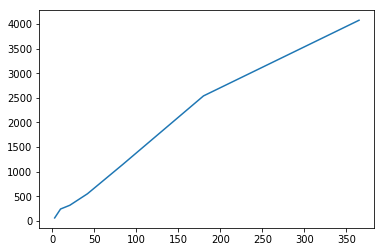

In [28]:
averageClones = [ sum([size*number for (size,number) in enumerate(t)])  for t in counts] 
plt.plot(times,averageClones)

In [29]:
def logLikelihood(obs,lp):
    if len(obs) > len (lp):
        maxClone = len(lp)
    else:
        maxClone = len(obs)
    def noisyMul(a,b,i):
        #print("logP",lp, "\nobsv", obs); lp[i]*obs[i]
        print("logP",a, "\nobsv", b)
        return(a[i]*b[i])
    return(sum([obs[i]*lp[i] for i in range(maxClone)]))

def allLogLike(obs,lp):
    return(sum([logLikelihood(o,p) for o,p in zip(obs,lp)]))

def sizesToFreq(sizes):
    biggest = max([max(c) for c in sizes])
    #print("Mean:",(sum(sizes)*surv))
    sizeList = [[t.count(s+1) for s in range(biggest)] for t in sizes]
    countPerTimePoint = [sum(s) for s in sizeList]
    logFreq = [[0 if total==0 or item==0 else math.log10(item/total) for item in n] for n,total in zip(sizeList,countPerTimePoint)]
    return(logFreq)
    
def fateToLogProbability(timePoints,fates,generations,div,strat):
    times = np.asarray([np.asarray(correctTime(c,0,div,strat,generations)) for c in fates])
    #count clone sizes at timepoints
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(cell[0],cell[1],t) for cell in clone]) for clone in times ] for t in timePoints]
    #for i,t in enumerate(cloneSizes):
    #    print(i,sum(t),t.count(0))
    #convert to log10(frequency)
    freq = sizesToFreq(cloneSizes)
    return(freq)

def parameterLike(rho,meanDivTime,timePoints,fates,generations,div,seed,data):
    #print("rho =",rho)
    stratTime = (1-rho)*meanDivTime/rho
    #print("\tstrat =",stratTime)
    strat = exponentialGenerate(seed,(stratTime))
    #Now get the probabilities
    lp = fateToLogProbability(timePoints,fates,generations,div,strat)
    #Now get the likelihoods
    like = allLogLike(data,lp)
    #print(like)
    return(like)

def searchRho(timePoints,r,rhoVals,sampleSize,seed,div,meanDivTime,data):
    #print("r =",r)
    random.seed(seed)
    generations = 230 
    def seedWrapper(r,generations,seed):
        random.seed(seed)
        clone = cell(0,True,r,random)
        return(cloneSimulateComplete(clone,generations))
    fates = np.asarray( [np.asarray(seedWrapper(r,generations,i)) for i in range(sampleSize)] )
    #check fate survival is sound
    def within(birth,death,time):
        if time>=birth and time<death:
            return(1)
        else:
            return(0)
    cloneSizes = [[sum([within(b,d,t/meanDivTime) for (b,d,p,s) in clone]) for clone in fates ] for t in timePoints]
    #for i,t in enumerate(cloneSizes):
    #    print(i,sum(t),t.count(0))
    return([parameterLike(rho,meanDivTime,timePoints,fates,generations,div,rhoSeed,data) for rhoSeed,rho in enumerate(rhoVals)])
    
def calculateLineageLikelihood(div,meanDivTime,data,bins,timePoints):
    rhoVals = [(i/bins+0.5/bins) for i in range(bins)] 
    rVals = [(i/(2*bins)+0.25/bins) for i in range(bins)] 
    #print("Testing:",rVals,rhoVals)
    sampleSize = 10000
    result = np.array([searchRho(timePoints,r,rhoVals,sampleSize,seed,div,meanDivTime,data) for (seed,r) in enumerate(rVals)])
    return(result)

In [30]:
bins = 5
expRate = exponentialGenerate(102,(2.4))
e = calculateLineageLikelihood(expRate,2.4,counts,bins,times)

In [31]:
def plotLikelihood(e):
    #Does some transformations to ensure that the graph is square, 
    # with r on x axis and rho on y, both increasing from bottom left
    plt.imshow((np.flip(np.transpose(e),axis=0)), cmap='coolwarm', interpolation='nearest',extent=[0,0.5,0,1],aspect=0.5)
    plt.colorbar()
    plt.show()

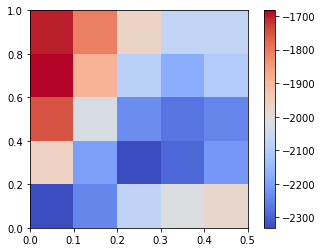

In [32]:
plotLikelihood(e)

In [33]:
gamRate = gammaGenerateDelay(102,(2.4,8.,0.5))
g = calculateLineageLikelihood(gamRate,2.4,counts,bins,times)

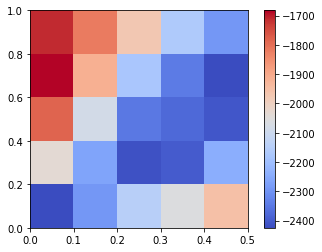

In [34]:
plotLikelihood(g)

# Histone dilution simulator

![Schematic of histone dilution experiment](histone.png)

The above code allows us to compare models directly with one type of experiment, lineage tracing. Another experiment is capable of giving us both the division rate and the shape of the rate distribution directly. This involves adding a label which is diluted every time the cell divides. If we measure the amount of label in cells that have divided different numbers of times, transform them with a logarithm to the base two, we can plot histograms of the label. This shows that as a population divides, the average label in each cell is roughly halved, and the mean of the distribution is reduced by one.

The label itself is fluorescent so the intensity of the label measured from a microscope image is used as a proxy for the quantity of label in a cell. We can model this dilution process and use the experimental data to search for the best sets of parameters using an approach known as approximate Bayesian computation (ABC).

First we will define a simulator to reproduce this process of dilution, and compare different distributions directly with experimental data. 

The simulator takes an array of initial intensities as an input, a noise function that reflects uneven partitioning of the label on cell division, a random number generator, a division time generator, and an array of the timepoints at which data were collected. The function randomly picks an initial intensity from the array (using the function *randomSample*), and generates new timepoints and associated intensities, by multiplying the previous intensity by 0.5 + the output of the noise function. The initial time is optionally reduced by a factor taken from a uniform random distribution. This is intended to reflect the fact that we do not start the experiment at the start of a division process, but instead part way through. 

Note that in contrast to the lineage tracing we don't take account of cell fate here, instead making a simplifying assumption of one stem cell dividing to give one stem cell (and a differentiated cell that is lost and not measured). 

Finally, we only return the intensities for a single cell at the experimental timepoints (as an array). This is done by going through each of the experimental times and comparing them to the paired simulated times/intensities.



In [35]:
class dilution:
    def __init__(self,init):
        self.label = init
        self.initial = None
    def pickInitial(self):
        self.initial = np.random.choice(self.label)
        return(self.initial)
    def next(self,n):
        return(np.cumprod(np.ones(n)/2)*self.pickInitial() )
        
class piedrafitaDilution(dilution):
    def next(self,n):
        dilutionFactors = np.ones(n)/2
        #Noise term based on uniform random distribution giving on average +/- 5%
        noiseTerms = np.random.uniform(-0.5,0.5,n)*math.sqrt(12)*0.06
        return(np.cumprod(dilutionFactors+noiseTerms)*self.pickInitial() )
        
def histoneIndividual(initialLabel,timePoints,timeRng,rate,dilute):
    diluteGen = dilute(initialLabel)
    times = [0]
    while(times[-1]<timePoints[-1]):
        times.append(timeRng.nextOne()+times[-1])
    times = np.array(times)
    dilutionTrace = diluteGen.next(len(times)-1)
    dilutionTrace = np.concatenate((np.array([diluteGen.initial]),dilutionTrace))
    def getTime(tx):
        return(np.where(tx>=times)[-1][-1])        
    intensity = np.array([dilutionTrace[getTime(t)] for t in timePoints])
    return(np.log2(intensity))
        
def histoneDilution(n,initialLabel,timePoints,timeRng,rate,dilute):
    return(np.array([histoneIndividual(initialLabel,timePoints,timeRng,rate,dilute) for i in range(n)]))


## Testing the simulators
Here we run some of the functions to explore how they behave and time some of the outputs. 


In [36]:
d = dilution(np.array([1.]))
d.next(10)

array([0.5       , 0.25      , 0.125     , 0.0625    , 0.03125   ,
       0.015625  , 0.0078125 , 0.00390625, 0.00195312, 0.00097656])

In [37]:
p = piedrafitaDilution(np.array([1.]))
p.next(10)

array([0.54719061, 0.26060581, 0.1219355 , 0.06489259, 0.02958867,
       0.01428605, 0.00644628, 0.00325794, 0.00183014, 0.00093224])

In [38]:
t = timeGenerate(1,())
histoneIndividual(np.array([1.]),[3,7,10],t,1,piedrafitaDilution)

array([ -3.26027524,  -8.08257696, -11.21848831])

## Reading experimental data, and visualising model and experimental results

We read some experimental data using pandas. initialIntensities are the initially measured intensities, whilst the later timepoints are stored in the array of arrays *measurementPopulations*. 

We also define a pair of utility functions that extend arrays with NaN values, or remove them.

In [39]:
def pad(a):
    topSize = max([len(i) for i in a])
    def complete(s):
        result = (np.ones(topSize)*np.nan)
        result[0:len(s)] = s
        return(result)
    return(np.array([complete(i) for i in a]))

def stripNaN(a):
    return(a[~np.isnan(a)])

def getData(filename):
    #reads a tsv file of histone intensities, concats the columns (i.e. mixing animals)
    df = pd.read_csv(filename, sep="\t")
    intensity = df.values.flatten()[~np.isnan(df.values.flatten())]
    return(intensity)

def dataToExperiment(intensity, timepoint, numberTimepoints):
    def blankExperiment(timepoint,numberTimepoints,i):
        r = np.ones(numberTimepoints)*np.nan
        r[timepoint] = i
        return(r)
    return([blankExperiment(timepoint,numberTimepoints,i) for i in intensity])
    
def loadExperiments(files):
    experiments = ([dataToExperiment(getData(filename),index,len(files)) for (index,filename) in enumerate(files)])
    #experiments = np.array([(index,filename) for (index,filename) in enumerate(files)])
    measurements = [item for sublist in experiments for item in sublist]
    return(measurements)

initialIntensities = getData("fake_0day.txt")


measurementPopulations =[   np.log2(getData("fake_7day.txt")),
                             np.log2(getData("fake_12day.txt")),
                             np.log2(getData("fake_18day.txt"))] 


## Comparing simulations with real data
Here we run 2 sets of simulations of ~1000 cells (roughly the number collected per animal) to visually compare the distributions with the experimental observations. Taking the same rates, we compare an exponential distribution for cell cycle times with a gamma distribution, with a shape of 8 and a fractional delay of 0.5. We then run the simulations and then plot the log2(intensities) from simulations and experimental data against one another using plotly. We use a log2 transformation as it allows us to more easily visualise the label intensity over time- at late timepoints the untransformed graph is highly skewed as the intensity is so low, and the log2 transformation specifically means that each division causes a reduction of label ~= 1 on the transformed graph.

By eye, you can observe that the gamma distribution is more realistic, giving more experimental-like distributions of label. The exponential distributions are broader than the gamma and experimental distributions as some cells divide very quickly, whilst others slowly. In contrast, theres a substantially narrower period of time when cells divide for the gamma distribution, meaning that more cells divide neat the average rate.

In each case we plot all timepoints for the experimental data, exponential simulation, and gamma simulation on a single graph. We then compare individual timepoints. As expected, the day 0 timepoints are identical to the experiment and one another, whilst the later timepoints are most dissimilar.

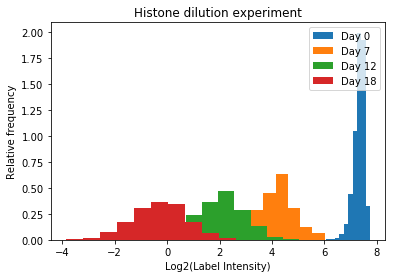

In [40]:
plt.hist(np.log2(initialIntensities), label='Day 0', normed=True)
plt.hist(measurementPopulations[0], label='Day 7', normed=True)
plt.hist(measurementPopulations[1], label='Day 12', normed=True)
plt.hist(measurementPopulations[2], label='Day 18', normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Relative frequency')
plt.title("Histone dilution experiment")

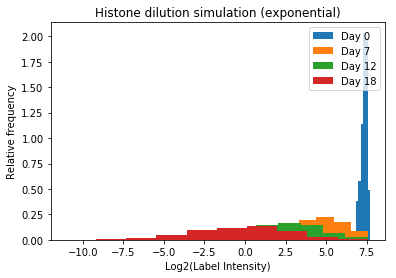

In [41]:
mean = 7./2.974
e = exponentialGenerate(1225,(mean))
expSim = np.transpose(histoneDilution(1000,initialIntensities,[0,7,12,18],e,mean,piedrafitaDilution))
plt.hist(expSim[0], label='Day 0', normed=True)
plt.hist(expSim[1], label='Day 7', normed=True)
plt.hist(expSim[2], label='Day 12', normed=True)
plt.hist(expSim[3], label='Day 18', normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Relative frequency')
plt.title("Histone dilution simulation (exponential)")

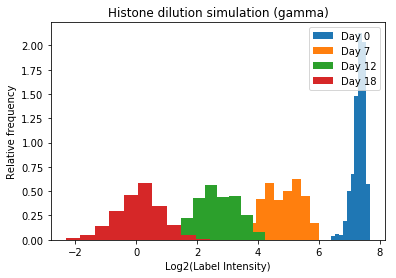

In [42]:
mean = 7./2.974
g = gammaGenerateFractionalDelay(1225,(mean,8,0.5))
gamSim = np.transpose(histoneDilution(1000,initialIntensities,[0,7,12,18],g,mean,piedrafitaDilution))
plt.hist(gamSim[0], label='Day 0', normed=True)
plt.hist(gamSim[1], label='Day 7', normed=True)
plt.hist(gamSim[2], label='Day 12', normed=True)
plt.hist(gamSim[3], label='Day 18', normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Relative frequency')
plt.title("Histone dilution simulation (gamma)")

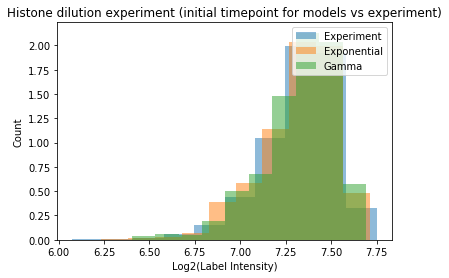

In [43]:
plt.hist(np.log2(initialIntensities), label='Experiment', alpha=0.5, normed=True)
plt.hist(expSim[0], label='Exponential', alpha=0.5, normed=True)
plt.hist(gamSim[0], label='Gamma', alpha=0.5, normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Count')
plt.title("Histone dilution experiment (initial timepoint for models vs experiment)")

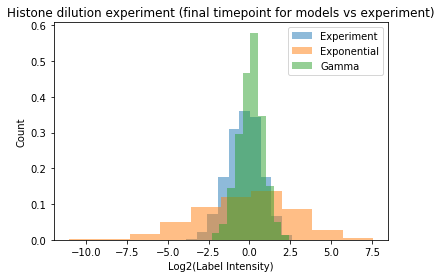

In [44]:
plt.hist(measurementPopulations[2], label='Experiment', alpha=0.5, normed=True)
plt.hist(expSim[3], label='Exponential', alpha=0.5, normed=True)
plt.hist(gamSim[3], label='Gamma', alpha=0.5, normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Count')
plt.title("Histone dilution experiment (final timepoint for models vs experiment)")

# ABC

The final task of this notebook is to find the best sets of parameters to describe the experimental data using the ABC approach. In the python notebook we were able to use a library pyabc to take care of the details of ABC.

To use pyabc we need to define;
1. A distance function, to measure quality of fit. Different distance functions can change your outputs- here we use a method based on the [KS test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) and quantile distances
2. A simulator that takes a dictionary as input with the model parameters as values, referenced by the parameter name

To summarise this process;

1. Generate initial set of parameters randomly, calculate distances, and calculate the median distance (epsilon)
2. Generate a new set of parameters by selecting from the initial set, making a perturbation to those parameters, and running simulations, rejecting those higher than the previous epsilon
3. Repeat 2, resetting epsilon to the median distance of the new population until you have either calculated enough populations of parameters or until you exceed a maximum number of tries.

Our key outputs here are to generate a scatter plot of accepted parameter sets, and a 2D KDE to show where the highest density of accepted parameters are. This should be able to show how the set of acceptable parameters starts off broad, but focuses down to a smaller set as the distance drops.


## New functions for pyabc

In pyabc, several functions need to be defined to generate simulated data, compare data etc. In each case they accept a dictionary and return a dictionary and so our original functions aren't suitable. Additionally, pyabc can run over multiple threads so the timegeneration functions are rewritten as they are not threadsafe.

To run pyabc, we need to define distance measures (*quantileStatistic* and *ksStatistic*), and a function that uses them to compare data and observations by reading a . We also define a model function- *histoneModelPop* (a wrapper for running *histoneModel* multiple times, for multiple cells).

We define the initial priors from a dictionary of tuples (*limits* for the boundaries of each variable and *parameter_prior* for priors), before passing these functions and additional run parameters to ABCSMC, creating the object *abc*. We store the observations in a database (using *abc.new*), whose location has been set in machine variables. Finally we start the calculation with *abc.run*, passing a few extra parameters. 

To visualise the results, we plot kernel density estimates of each of the posterior distributions and a multipanel plot (using *plot_kde_2d*) of the final population with scatter and histograms of parameters

In [45]:
def distance(sim,data):
    #return(np.nanmin(np.log2(a)-np.log2(b))**2)
    if np.isinf(sim["i"]).any():
        return(np.inf)
    else:
        #return(0)
        simData = sim["i"]
        #print(simData)
        d = sp.absolute(np.nanmin(simData-data["i"]))
        return(np.sum(d))

def quantileStatistic(o,m):
    #piedrafita summary stat
    oq = np.quantile(o,[0.025,0.25,0.5,0.75,0.975])
    mq = np.quantile(m,[0.025,0.25,0.5,0.75,0.975])
    r = sp.absolute(oq-mq)
    #print("o",oq)
    #print("m",mq)
    #print(r)
    return(sum(r))    
        
def ksStatistic(o,m):
    #print("%dx%d\n" % (len(o), len(m)) )
    k,p = stats.ks_2samp(o,m)
    return(k)

def distancePopulation(summStat,sim,data):
    if np.isinf(sim["i"]).any():
        return(np.inf)
    else:
        modelResults = sim["i"]
        observations = data["i"] 
        results = [summStat(stripNaN(observations[i]),modelResults[:,i]) for i in [0,1,2]]
        #print(results)
        return(sum(results))
        

In [46]:
def histoneModel(p):
    #measurement time, rate, shape of gamma dist, time period for refrac, dilution func
    #(time,mean,shape,refrac,dilute) = parameters 
    #use rate to estimate how many rngs we want (padded by 1000%)
    
    #Fixed parameters of the model
    timeSource = [7,12,18] #in days
    diluteSource = piedrafitaDilution(initialIntensities)
    meanSource = 7/3
    randomiseInitialTime = True
    
    #reimplemented to ensure threadsafety...
    def drawTimes(mean,delay,shape,lastTime):
        #draws 10 times, then checks last time. If insufficient, draw ten at a time
        lagTime = mean*delay
        divTime = mean*(1-delay)
        if randomiseInitialTime:
            t0 = np.random.uniform() * (lagTime+np.random.gamma(shape,divTime/shape))
            initial = np.array([0,t0])
        else: 
            initial = np.array([0])
        times = np.concatenate(( initial,np.cumsum(lagTime+np.random.gamma(shape,divTime/shape,9)) ))
        while times[-1]<lastTime:
            newTimes = np.cumsum(lagTime+np.random.gamma(shape,divTime/shape,10)) + times[-1]
            times = np.concatenate( (times,newTimes) )
        return(times)
    #get out early if silly input
    if meanSource<=p["delay"]:
        return({"i":np.ones(len(timeSource))*np.inf})
    else:
        times = drawTimes(meanSource,p["delay"],(2**p["log2shape"]),timeSource[-1])
        newLabelIntensities = diluteSource.next(len(times)-1)# generate new dilutions
        labelIntensities = np.concatenate((np.array([diluteSource.initial]),newLabelIntensities))
        #Find the timepoints; 
        def getTime(tx):
            return(np.where(tx>=times)[0][-1])
        #Get the label at that time
        intensity = np.log2(np.array([labelIntensities[getTime(t)] for t in timeSource]))
        # return the sample as dictionary
        return {"i": intensity}
    
def histoneModelPop(p):
    #run the histone model 1000 times then return all the results as a matrix
    #1000 cells ~= 1 animal
    intensity = np.array([(histoneModel(p))["i"] for i in range(1000)])
    return( {"i" : intensity})


## Testing the simulator and distance functions

Here we run through a single set of model simulations with selected parameters to confirm that the functions work correctly together. These outputs can be directly compared with those from the F# code, and be found to give similar results, showing that the results are reproducible.

In [47]:
sim = histoneModelPop({"delay":0.5,"log2shape":2})

In [48]:
simRead = np.transpose(sim["i"])

In [49]:
measurementPopulations

[array([4.2777542 , 4.59732855, 3.53786756, ..., 3.70439615, 4.32570301,
        3.99694908]),
 array([1.89623309, 2.7654711 , 2.57741674, ..., 1.81860518, 1.77420723,
        1.79730356]),
 array([-0.25601118,  0.29947913, -0.54245824, ..., -0.6861737 ,
        -1.87038726,  0.07423139])]

In [50]:
distancePopulation(ksStatistic,sim,{"i": pad(measurementPopulations)})

0.7486666666666666

In [51]:
for i in [0,1,2]:
    print(ksStatistic(simRead[i],measurementPopulations[i]))

0.22633333333333333
0.23766666666666664
0.2846666666666667


In [52]:
measurementPopulations[0]

array([4.2777542 , 4.59732855, 3.53786756, ..., 3.70439615, 4.32570301,
       3.99694908])

In [53]:
simRead[0]

array([3.34768643, 2.95066966, 5.03603313, 3.09998421, 3.66225114,
       3.65627782, 4.65171082, 4.01523972, 3.23686611, 3.09168193,
       3.77948018, 3.04475207, 4.37083948, 3.69127444, 2.75408167,
       3.46698734, 3.58109461, 4.19273438, 5.26398601, 4.22976782,
       4.23398156, 3.34941292, 4.10676657, 4.8343172 , 3.06231533,
       3.43883261, 2.35644116, 4.2033976 , 4.01590002, 4.50716652,
       3.92874639, 3.8840004 , 3.89239239, 4.77015854, 4.54102481,
       3.39488599, 3.38971322, 3.93192334, 3.99652323, 4.19028116,
       4.57682777, 4.24187881, 2.30434306, 3.56896786, 2.76045317,
       3.12329424, 4.47623405, 4.66264702, 4.51428818, 3.1519844 ,
       3.6615005 , 4.50237123, 3.50504745, 2.64645244, 3.34556023,
       4.52950288, 3.49759547, 3.77914821, 4.56363395, 2.50509898,
       3.41867293, 4.14456755, 4.09900245, 3.90735183, 4.72528086,
       3.66692   , 2.84954731, 3.65561036, 3.98750807, 4.68843656,
       2.92357148, 4.15884539, 4.79298748, 4.3056128 , 4.43637

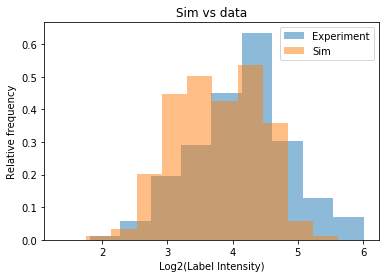

In [54]:
plt.hist(measurementPopulations[0], label='Experiment', alpha=0.5, normed=True)
plt.hist(simRead[0], label='Sim', alpha=0.5, normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Relative frequency')
plt.title("Sim vs data")

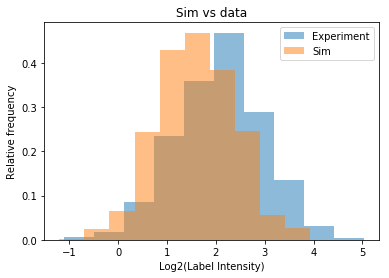

In [55]:
plt.hist(measurementPopulations[1], label='Experiment', alpha=0.5, normed=True)
plt.hist(simRead[1], label='Sim', alpha=0.5, normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Relative frequency')
plt.title("Sim vs data")

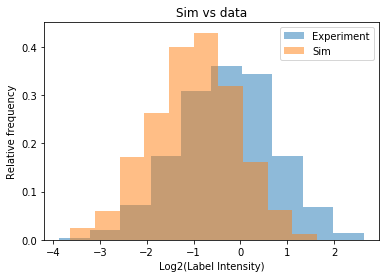

In [56]:
plt.hist(measurementPopulations[2], label='Experiment', alpha=0.5, normed=True)
plt.hist(simRead[2], label='Sim', alpha=0.5, normed=True)
plt.legend(loc='upper right')
plt.xlabel('Log2(Label Intensity)')
plt.ylabel('Relative frequency')
plt.title("Sim vs data")

## ABC search for acceptable parameters

Below we search for the best fitting parameters with a fractional delay of zero to one, and a shape from 1 to 64. 

In [57]:
limits = dict(delay=(0, 1),
              log2shape=(0, 6)
             )

In [58]:
parameter_prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [59]:
abc = ABCSMC(models=histoneModelPop,
             parameter_priors=parameter_prior,
             distance_function=partial(distancePopulation,quantileStatistic), #qs eps ~ 30, ks eps ~ 2
             population_size=200,
             transitions=LocalTransition(k_fraction=.3),
             eps=MedianEpsilon(30, median_multiplier=0.99))

In [60]:
abc.new(db_path, {"i": pad(measurementPopulations)});

INFO:History:Start <ABCSMC(id=1, start_time=2019-04-29 15:22:46.457166, end_time=None)>


In [61]:
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:ABC:t:0 eps:30
INFO:ABC:t:1 eps:8.016870132486643
INFO:ABC:t:2 eps:7.620873470062113
INFO:ABC:t:3 eps:7.404606675585062
INFO:ABC:t:4 eps:7.237804947905661
INFO:History:Done <ABCSMC(id=1, start_time=2019-04-29 15:22:46.457166, end_time=2019-04-29 15:35:23.192933)>


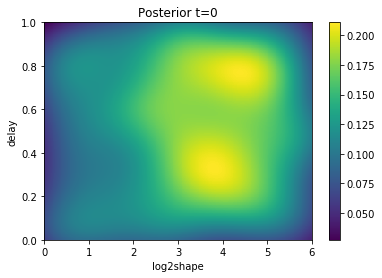

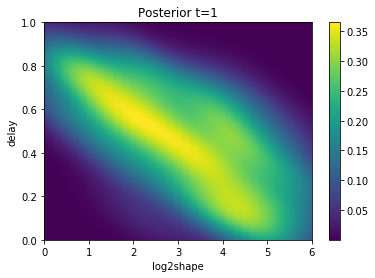

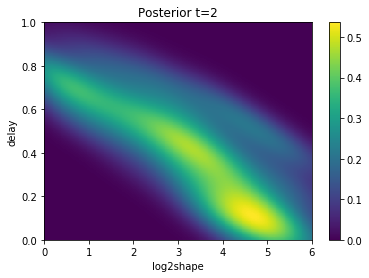

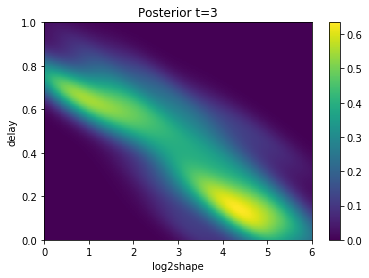

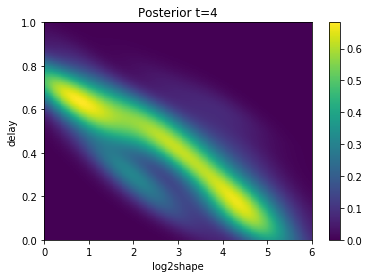

In [62]:
for t in range(h.max_t+1):
    ax = plot_kde_2d(*h.get_distribution(m=0, t=t),
                     "log2shape", "delay",
                xmin=0, xmax=6, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.set_title("Posterior t={}".format(t))


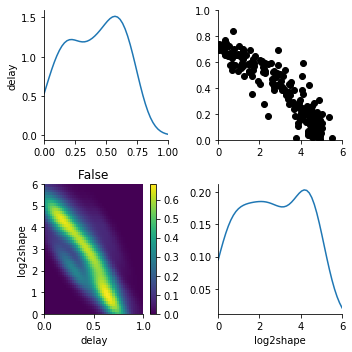

In [63]:
from pyabc.visualization import plot_kde_matrix

df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

In [64]:
abc = ABCSMC(models=histoneModelPop,
             parameter_priors=parameter_prior,
             distance_function=partial(distancePopulation,ksStatistic), #qs eps ~ 30, ks eps ~ 2
             population_size=200,
             transitions=LocalTransition(k_fraction=.3),
             eps=MedianEpsilon(2, median_multiplier=0.95))
abc.new(db_path, {"i": pad(measurementPopulations)});
h = abc.run(minimum_epsilon=0.1, max_nr_populations=4)

INFO:History:Start <ABCSMC(id=2, start_time=2019-04-29 15:35:35.829024, end_time=None)>
INFO:ABC:t:0 eps:2
INFO:ABC:t:1 eps:0.8207999999999999
INFO:ABC:t:2 eps:0.7328356242696386
INFO:ABC:t:3 eps:0.6778974691474193
INFO:History:Done <ABCSMC(id=2, start_time=2019-04-29 15:35:35.829024, end_time=2019-04-29 15:48:16.853518)>


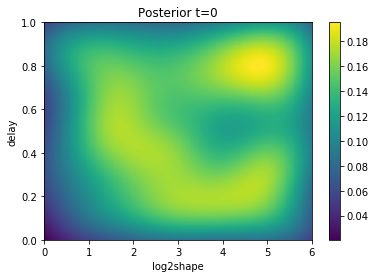

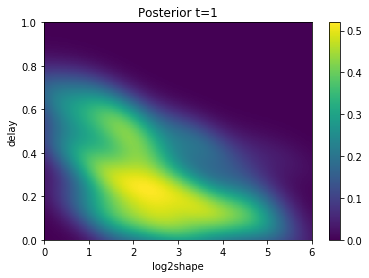

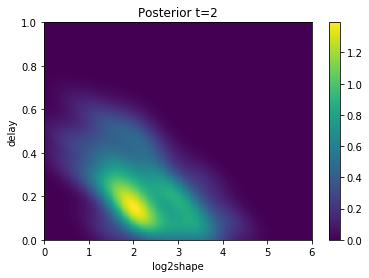

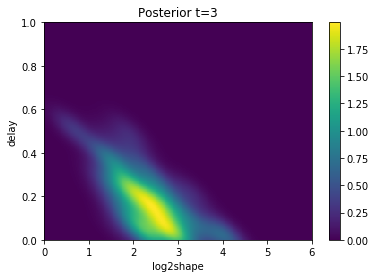

In [65]:
for t in range(h.max_t+1):
    ax = plot_kde_2d(*h.get_distribution(m=0, t=t),
                     "log2shape", "delay",
                xmin=0, xmax=6, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.set_title("Posterior t={}".format(t))

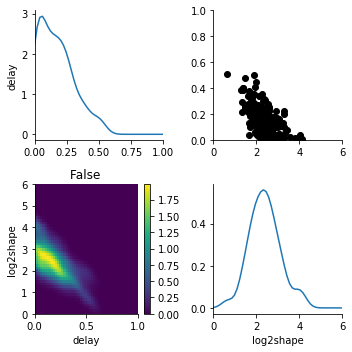

In [66]:
from pyabc.visualization import plot_kde_matrix

df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

## Adaptive ABC experiments

This final section explores the same model as above but using adaptive weighting using different distance metrics. Its intended to just demonstrate how the different results from each analysis can be brought together.

In [67]:
def histoneModelPopAdaptive(p):
    #run the population model, but return summary stats for adaptive abc
    sim = histoneModelPop(p)
    data = {"i": pad(measurementPopulations)}
    return({"ks": distancePopulation(ksStatistic,sim,data), "quantile": distancePopulation(quantileStatistic,sim,data)})

observation= {"ks":0,"quantile":0}

distance = AdaptivePNormDistance(p=2, adaptive=True)
#model = partial(histoneModelPopAdaptive, {"i": pad(measurementPopulations)})
abc = ABCSMC(histoneModelPopAdaptive, parameter_prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "as2.db")
abc.new(db_path,observation)
history2 = abc.run(minimum_epsilon=.1, max_nr_populations=5)


INFO:History:Start <ABCSMC(id=1, start_time=2019-04-29 15:48:27.035487, end_time=None)>
INFO:Epsilon:initial epsilon is 1.8785832478824078
INFO:ABC:t:0 eps:1.8785832478824078
INFO:ABC:t:1 eps:1.7184755122260027
INFO:ABC:t:2 eps:1.78759573784781
INFO:ABC:t:3 eps:1.715271692658879
INFO:ABC:t:4 eps:1.7719046740779258
INFO:History:Done <ABCSMC(id=1, start_time=2019-04-29 15:48:27.035487, end_time=2019-04-29 15:51:40.432043)>


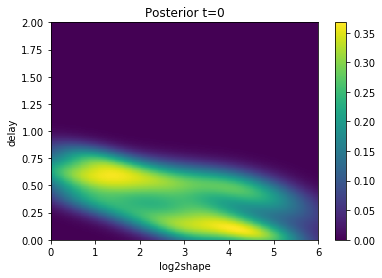

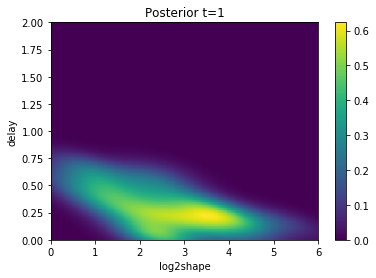

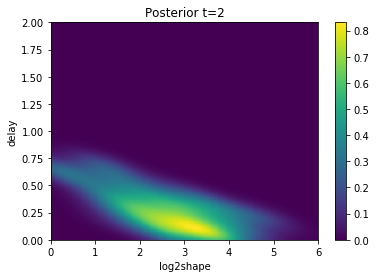

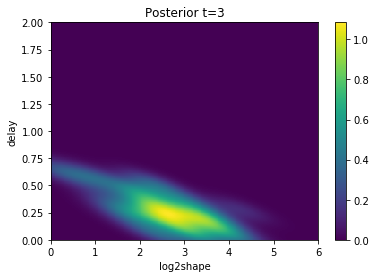

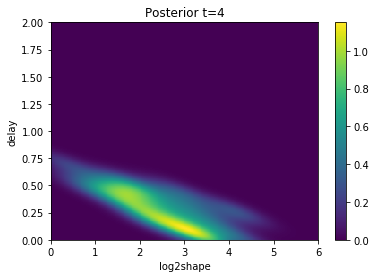

In [68]:
for t in range(history2.max_t+1):
    ax = plot_kde_2d(*history2.get_distribution(m=0, t=t),
                     "log2shape", "delay",
                xmin=0, xmax=6, numx=300,
                ymin=0, ymax=2, numy=300)
    ax.set_title("Posterior t={}".format(t))

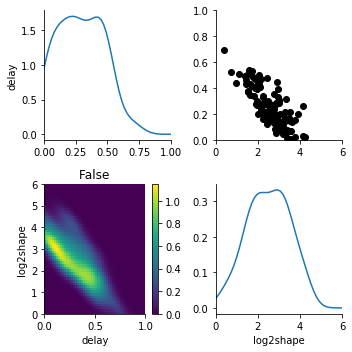

In [69]:
df, w = history2.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

# Conclusions

We've shown how you can build simulators, visualise their results, and use them to analyse experimental data. This has been achieved using available libraries and tools to plot the results in the notebook. Each function can be rerun with altered parameters and explored in the notebook, or even rewritten to analyse your own data!